# Leukemia Remission Times

These data are the times of remission (in weeks) of leukemia patients.
Out of the 42 total patients, 21 were in a control group, and the other 21 were in a treatment group.
Patients were observed until their leukemia symptoms relapsed or until the study ended, whichever occurred first.
Each patient in the control group experienced relapse before the study ended, while 12 patients in the treatment group did not come out of remission during the study.
Thus, there is heavy right-censoring in the treatment group and no right-censoring in the control group.

One of the questions to ask about this dataset is whether the treatment prolonged the time until relapse.
Formally, we are interested in whether there is a statistical difference between the time-to-relapse distributions of the control and treatment groups.
In this notebook we will use the `survive` package to investigate this question.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

from survive import datasets
from survive import SurvivalData
from survive import KaplanMeier, NelsonAalen

## Loading the dataset

The `leukemia()` function in the `survive.datasets` module loads a pandas DataFrame containing the leukemia data.
The columns of this DataFrame are

* `time` - The patients' observed leukemia remission times (in weeks).
* `status` - Event/censoring indicator: 1 indicates that the patient's leukemia relapsed, and 0 indicates that the study ended before relapse.
* `group` - Indicates whether a patient is from the control or treatment group.

In [2]:
leukemia = datasets.leukemia()
display(leukemia.head())

,time,status,group
patient,,,
0,1,1,control
1,1,1,control
2,2,1,control
3,2,1,control
4,3,1,control


## Exploratory data analysis with `SurvivalData`

The `SurvivalData` class is a fundamental class for storing and dealing with survival/lifetime data.
It is aware of groups within the data and allows quick access to various important quantities (like the number of events or the number of individuals at risk at a certain time).

If your survival data is stored in a pandas DataFrame (like the leukemia data is), then a `SurvivalData` object can be created by specifying the DataFrame and the names of the columns corresponding to the observed times, censoring indicators, and group labels.

In [3]:
surv = SurvivalData(time="time", status="status", group="group", df=leukemia)

Alternatively, you may specify one-dimensional arrays of observed times, censoring indicators, and group labels directly.
This is so that your can use `SurvivalData` even if your data aren't stored in a DataFrame.

In [4]:
# Equivalent to the constructor call above
surv = SurvivalData(time=leukemia.time, status=leukemia.status,
                    group=leukemia.group)

### Describing the data

Printing a `SurvivalData` object shows the observed survival times within each group.
Censored times are marked by a plus by default (indicating that the true survival time for that individual might be longer).

In [5]:
print(surv)

control

 1  1  2  2  3  4  4  5  5  8  8  8  8 11 11 12 12 15 17 22 23

treatment

 6   6   6   6+  7   9+ 10  10+ 11+ 13  16  17+ 19+ 20+ 22  23  25+ 32+ 32+
34+ 35+


The `describe` property of a `SurvivalData` object is a pandas DataFrame containing simple descriptive statistics of the survival data.

In [6]:
display(surv.describe)

,total,events,censored
group,,,
control,21,21,0
treatment,21,9,12


### Visualizing the survival data

The `plot_lifetimes()` method of a `SurvivalData` object plots the observed lifetimes of all the individuals in the data.
Censored individuals are marked at the end of their lifespan.

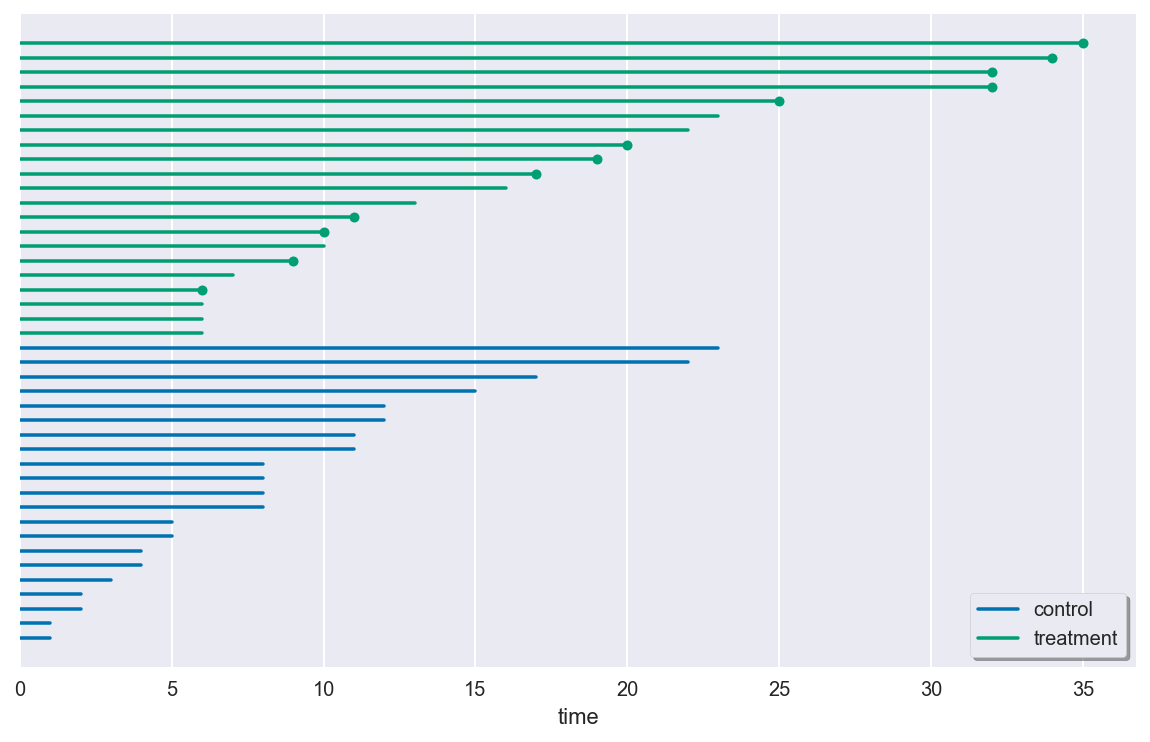

In [7]:
plt.figure(figsize=(10, 6))
surv.plot_lifetimes()
plt.show()
plt.close()

There are many longer remission times observed in the treatment group.
However, while this observation is encouraging, it is is not enough evidence to guarantee a statistically significance treatment effect.

### Computing the number of events and number of individuals at risk

You can compute the number of events that occured at a given time within each group using the `n_events()` method, which returns a pandas DataFrame.

In [8]:
display(surv.n_events([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))

group,control,treatment
time,,
1,2,0
2,2,0
3,1,0
4,2,0
5,2,0
6,0,3
7,0,1
8,4,0
9,0,0


In a survival study, the number of individuals "at risk" at any given time is defined to be the number of individuals who have entered the study by that time and have not yet experienced an event or censoring immediately before that time.
This number over time is called the *at-risk process*.

You can compute the number of individuals at risk within each group at a given time using the `n_at_risk()` method.
Like `n_events()`, this method also returns a DataFrame.

In [9]:
display(surv.n_at_risk([0, 5, 10, 20, 25, 30, 35]))

group,control,treatment
time,,
0,0,0
5,14,21
10,8,15
20,2,8
25,0,5
30,0,4
35,0,1


### Plotting the at-risk process

You can plot the at-risk process using the `plot_at_risk()` method of a `SurvivalData` object.

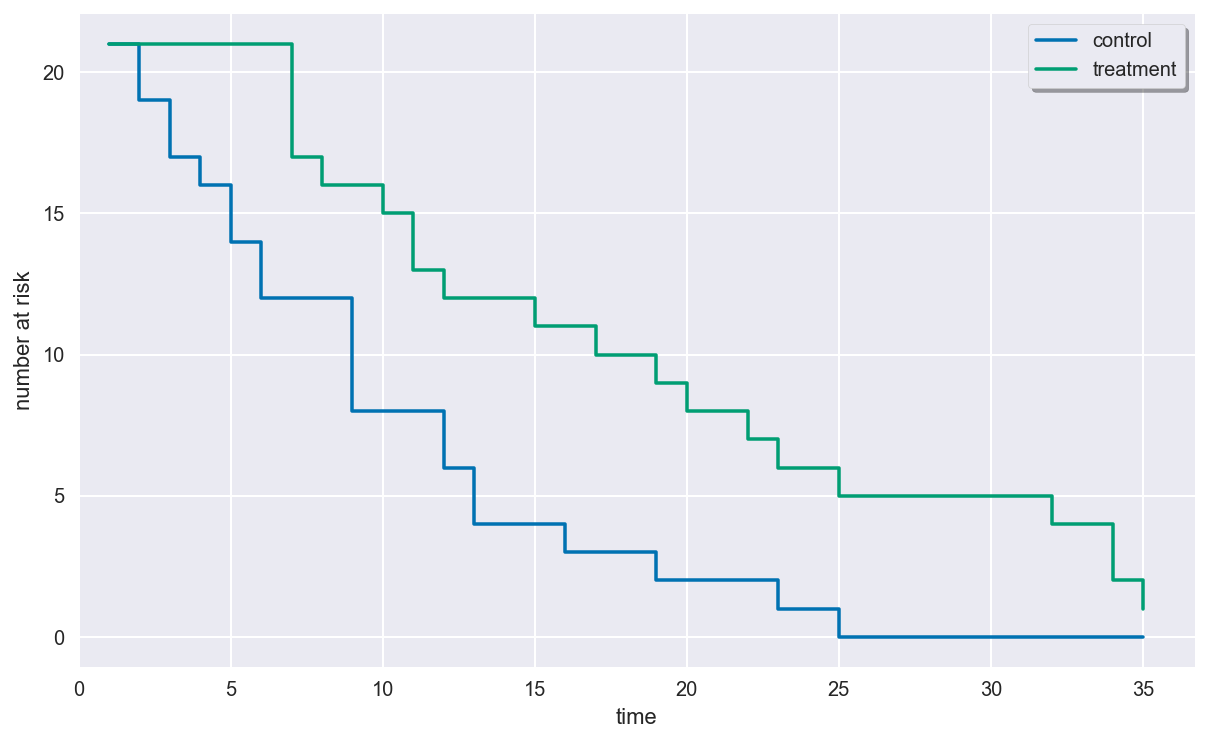

In [10]:
plt.figure(figsize=(10, 6))
surv.plot_at_risk()
plt.show()
plt.close()

## Estimating the survival function with `KaplanMeier`

### Kaplan-Meier estimator

The *Kaplan-Meier estimator* (AKA *product limit estimator*) is a nonparametric estimator of the survival function of the time-to-event distribution that can be used even in the presence of right-censoring.

The `KaplanMeier` class implements the Kaplan-Meier estimator.

### Initializing the estimator

You can initialize a `KaplanMeier` object with no parameters.

In [11]:
# Kaplan-Meier estimator to be used for the leukemia data
km = KaplanMeier()

Now `km` is a Kaplan-Meier estimator waiting to be fitted to survival data.
We didn't pass any parameters to the initializer of the Kaplan-Meier estimator, but we could have.
Printing a `KaplanMeier` object shows what initializer parameter values were used for that object (and default values for parameters that weren't specified explicitly).

In [12]:
print(km)

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')


We'll use these default parameters.

### Fitting the estimator to the leukemia data

We can fit our Kaplan-Meier estimator to the leukemia data using the `fit()` method.
There are a few ways of doing this, but the easiest is to pass it an existing `SurvivalData` instance.

In [13]:
km.fit(surv)

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')

The other ways to call `fit()` are described in the method's docstring.
Note that `fit()` fits the estimator in-place and returns the estimator itself.

### Summarizing the fit

Once the estimator is fitted, the `summary` property of a `KaplanMeier` object tabulates the survival probability estimates and thier standard error and confidence intervals for the event times within each group.
It can be printed to display all the information at once.

In [14]:
print(km.summary)

Kaplan-Meier estimator

control

total  events  censored
                       
   21      21         0

time  events  at risk  estimate  std. error  95% c.i. lower  95% c.i. upper
   1       2       21  0.904762    0.064056        0.670046        0.975294
   2       2       19  0.809524    0.085689        0.568905        0.923889
   3       1       17  0.761905    0.092943        0.519391        0.893257
   4       2       16  0.666667    0.102869        0.425350        0.825044
   5       2       14  0.571429    0.107990        0.337977        0.749241
   8       4       12  0.380952    0.105971        0.183067        0.577789
  11       2        8  0.285714    0.098581        0.116561        0.481820
  12       2        6  0.190476    0.085689        0.059482        0.377435
  15       1        4  0.142857    0.076360        0.035657        0.321162
  17       1        3  0.095238    0.064056        0.016259        0.261250
  22       1        2  0.047619    0.046471        0.00332

*Note:* The NaNs (not a number) appearing in the summary are caused by the standard error estimates not being defined when the survival function estimate is indentically zero.
This is expected behavior.

### Visualizing the fit

The estimated survival curves for the two groups can be drawn using the `plot()` method of the `KaplanMeier` object.
By default, censored times in the sample are indicated by plus signs on the curve.

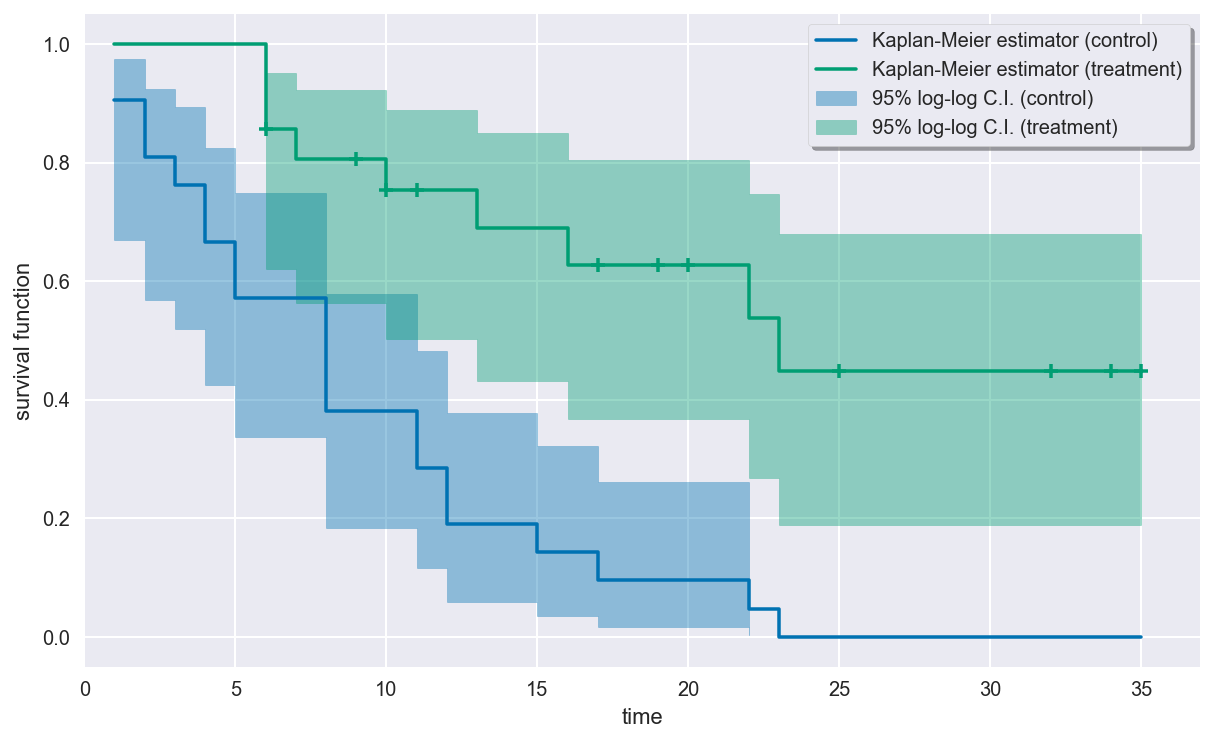

In [15]:
plt.figure(figsize=(10, 6))
km.plot()
plt.show()
plt.close()

The plot seems to indicate that the patients in the treatment group are more likely to have longer remission times than patients in the control group.

### Estimating survival probabilities

The `predict()` method of a `KaplanMeier` object returns a pandas DataFrame of estimated probabiltiies for surviving past a certain time for each group.

In [16]:
estimate = km.predict([5, 10, 15, 20, 25])
display(estimate)

group,control,treatment
time,,
5,0.571429,1.000000
10,0.380952,0.752941
15,0.142857,0.690196
20,0.095238,0.627451
25,0.000000,0.448179


### Estimating time-to-event distribution quantiles

The `quantile()` function of a `KaplanMeier` object returns a pandas DataFrame of empirical quantile estimates for the time-to-relapse distribution

In [17]:
quantiles = km.quantile([0.25, 0.5, 0.75])
display(quantiles)

group,control,treatment
prob,,
0.25,4.0,13.0
0.50,8.0,23.0
0.75,12.0,NaN


## Estimating the cumulative hazard with `NelsonAalen`

### Nelson-Aalen estimator

The *Nelson-Aalen estimator* is a nonparametric estimator of the cumulative hazard of the time-to-event distribution.
The `NelsonAalen` class implements this estimator.
Its API is nearly identical to the `KaplanMeier` API described above.

### Initializing and fitting the estimator

You can initialize a `NelsonAalen` object with no parameters and call the `fit()` methon on the leukemia data.

In [18]:
na = NelsonAalen()
na.fit(surv)

NelsonAalen(conf_level=0.95, conf_type='log', tie_break='discrete',
            var_type='aalen')

### Visualizing the estimated cumulative hazard

The estimated cumulative hazard for the two groups can be drawn using the `plot()` method of the `NelsonAalen` object.
By default, censored times in the sample are indicated by plus signs on the curve.

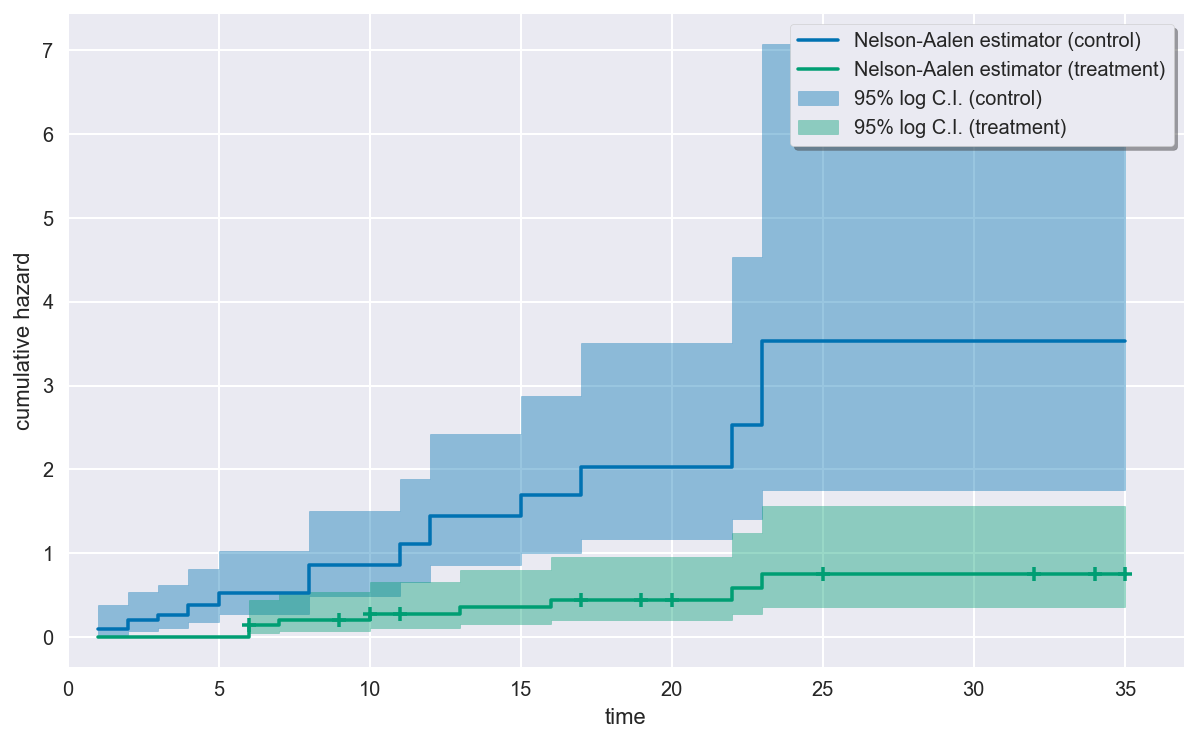

In [19]:
plt.figure(figsize=(10, 6))
na.plot()
plt.show()
plt.close()